In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, shutil
from glob import glob
import random

original_path = "/content/drive/My Drive/Plant_Dataset"
dataset_path = "/content/plant_half_dataset"

os.makedirs(dataset_path, exist_ok=True)

classes = os.listdir(original_path)

for cls in classes:
    src_folder = os.path.join(original_path, cls)
    if not os.path.isdir(src_folder):
        continue

    imgs = glob(src_folder + "/*")
    half_count = len(imgs) // 2     # use 50% images
    selected = random.sample(imgs, half_count)

    dest_folder = os.path.join(dataset_path, cls)
    os.makedirs(dest_folder, exist_ok=True)

    for img in selected:
        shutil.copy(img, dest_folder)

print("Half dataset created at:", dataset_path)


Half dataset created at: /content/plant_half_dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.30
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 11682 images belonging to 7 classes.
Found 5001 images belonging to 7 classes.
Classes: ['Apple', 'Corn', 'Grape', 'Peach', 'Potato', 'Strawberry', 'Tomato']


In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

for layer in base_model.layers:
    layer.trainable = False   # Freeze layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,055 (91.99 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
EPOCHS = 10  # increase if accuracy < 85%

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 289s 749ms/step - accuracy: 0.4689 - loss: 1.6651 - val_accuracy: 0.5347 - val_loss: 1.4604
Epoch 2/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 252s 688ms/step - accuracy: 0.5289 - loss: 1.4869 - val_accuracy: 0.5347 - val_loss: 1.4235
Epoch 3/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 249s 681ms/step - accuracy: 0.5414 - loss: 1.4210 - val_accuracy: 0.5347 - val_loss: 1.3936
Epoch 4/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 245s 670ms/step - accuracy: 0.5380 - loss: 1.3949 - val_accuracy: 0.5361 - val_loss: 1.3622
Epoch 5/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 246s 673ms/step - accuracy: 0.5392 - loss: 1.3597 - val_accuracy: 0.5373 - val_loss: 1.3402
Epoch 6/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 246s 672ms/step - accuracy: 0.5353 - loss: 1.3475 - val_accuracy: 0.5541 - val_loss: 1.3047
Epoch 7/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 244s 668ms/step - accuracy: 0.5669 - loss: 1.2684 - val_accuracy: 0.5619 - val_loss: 1.2764
Epoch 8/10
366/366 ━━━━━━━━━━━━━━━━━━━━ 244s 667ms/step - accuracy: 0.5758 -

In [ ]:
model.save("/content/drive/MyDrive/plant_resnet_model.keras")
print("Model Saved Successfully!")


Model Saved Successfully!


In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/plant_resnet_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,       # continue until 20
    initial_epoch=10  # skip first 10 epochsa
)


Epoch 11/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 281s 730ms/step - accuracy: 0.5593 - loss: 1.3558 - val_accuracy: 0.5633 - val_loss: 1.2576
Epoch 12/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 258s 705ms/step - accuracy: 0.5887 - loss: 1.2081 - val_accuracy: 0.5959 - val_loss: 1.1932
Epoch 13/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 250s 682ms/step - accuracy: 0.5997 - loss: 1.1494 - val_accuracy: 0.5975 - val_loss: 1.2015
Epoch 14/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 248s 679ms/step - accuracy: 0.6254 - loss: 1.0870 - val_accuracy: 0.6531 - val_loss: 1.0988
Epoch 15/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 248s 677ms/step - accuracy: 0.6462 - loss: 1.0422 - val_accuracy: 0.6163 - val_loss: 1.1599
Epoch 16/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 251s 685ms/step - accuracy: 0.6426 - loss: 1.0223 - val_accuracy: 0.6067 - val_loss: 1.2010
Epoch 17/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 251s 685ms/step - accuracy: 0.6571 - loss: 0.9924 - val_accuracy: 0.6347 - val_loss: 1.0446
Epoch 18/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 249s 680ms/step - accuracy: 

In [ ]:
model.save("/content/drive/MyDrive/plant_resnet_model_updated.keras")
print("Model Saved Successfully!")


Model Saved Successfully!


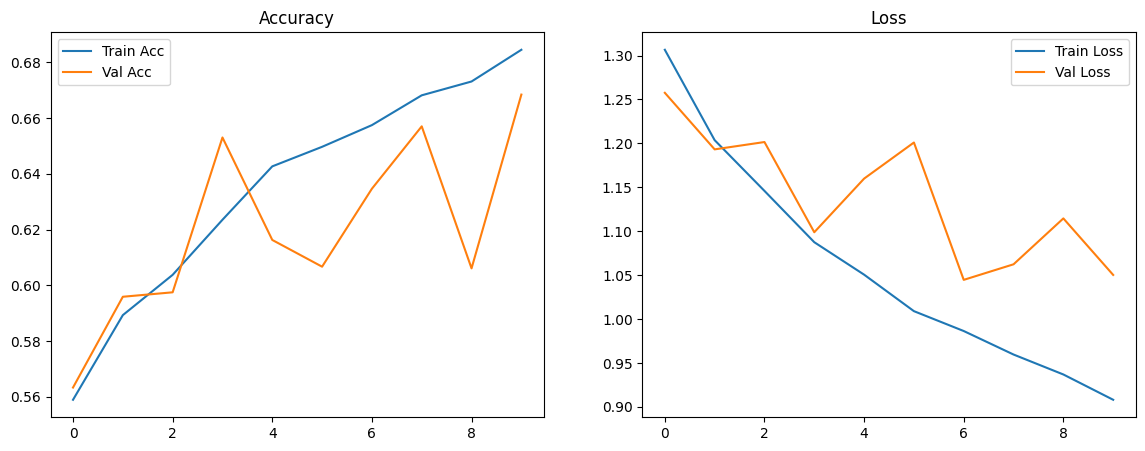

In [ ]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 455ms/step


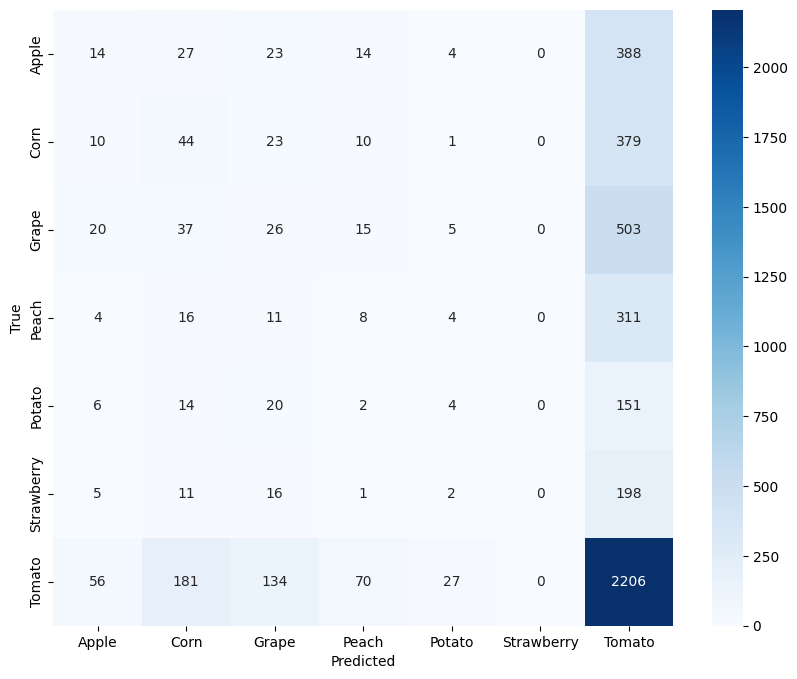

              precision    recall  f1-score   support

       Apple       0.12      0.03      0.05       470
        Corn       0.13      0.09      0.11       467
       Grape       0.10      0.04      0.06       606
       Peach       0.07      0.02      0.03       354
      Potato       0.09      0.02      0.03       197
  Strawberry       0.00      0.00      0.00       233
      Tomato       0.53      0.82      0.65      2674

    accuracy                           0.46      5001
   macro avg       0.15      0.15      0.13      5001
weighted avg       0.33      0.46      0.37      5001



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(val_gen.classes, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(val_gen.classes, y_pred, target_names=class_names))


In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/plant_resnet_model_updated.keras")

In [ ]:
import cv2

img_path = "/content/drive/My Drive/Plant_Dataset/Apple/FREC_C.Rust_0059_resized.JPG"

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_id = np.argmax(pred)
print("Predicted Class:", class_names[class_id])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted Class: Tomato
